In [1]:
import numpy as np
import matplotlib.pyplot as plt
import paleo_bulk
from scipy.stats import gaussian_kde
import itertools

# 5 - Bulk Analysis of cell tracks 

In this notebook we will use a combination of detected spots from Mastodon and Masks from labkit in order to choose regions of interest. 

Moreover, we will also be able to edit files from Mastodon in order to be able to observe cell tracks we choose in the user interface of BigDataViewer with Mastodon. 

## Folder and data paths
In the next cell, you need to specify:
- ``path_xml``: Path and file name of the .xml file obtained from converting the data to HDF5/XML is stored.
- ``path_labels``: Path and file name of the .xml.labeling file obtained from the Labkit Fiji Plugin. Before loading it, remove the .labeling extension so that it only has the .xml extension. 

<div class="alert alert-block alert-warning">
    <b>WARNING:</b> Be careful not to overwrite your .xml created from the HDF5/XML.
</div>

- ``path_mamut``: Path and dile name of the mamut.xml file obtained from Mastodon. This file can be edited in order to interact with Mastodon. 

In [2]:
# Path to .xml file generated when creating the .hdf5
path_xml = '../Data/Bulk_Data/dataset.xml'

# Path to mamut.xml file
path_mamut = '../Data/Bulk_Data/dataset_mamut.xml'

# Path to the Labeling
path_labels = '../Data/Bulk_Data/dataset_labels.xml'

path_save = '../Data/Bulk_Data'

In [3]:
# Path to .xml file generated when creating the .hdf5
path_xml = '../Data/Ece/p2_fr61.xml'

# Path to mamut.xml file
path_mamut = '../Data/Ece/211216_p2_fr61_mamut.xml'

# Path to the Labeling
path_labels = '../Data/Ece/211216_p2_fr61_labels.xml'

In [4]:
features = paleo_bulk.XMLParser(path_xml, path_mamut, 1)

The image has the following dimensions (XYZC): 2048, 2048, 77, 5
There are 1 frames in total.
Pixel Size: x = 0.347 µm, y = 0.347 µm z = 3 µm
There are 77 Z-slices in total


There are 6932 number of cells in total in Looping.
There are 0 number of cell tracks in total in Looping.


## Ordering the tracks ID

Here we define an object called ``spots`` which includes:
- ``n_spots_in_frame`` : The number of spots in each frame
- ``spots_ID_per_frame`` : The ID for each spot in each frame
- ``spots_trackID_per_frame`` : The track ID for each cell in each frame
- ``spots_xpos_per_frame`` : X-coordinates of each spot in each frame
- ``spots_ypos_per_frame`` : Y-coordinates of each spot in each frame
- ``spots_zpos_per_frame`` : Z-coordinates of each spot in each frame

All of these lists have a similar structure, for example ``spots_track_ID`` looks as following:

[ track number 1: { spot ID 1, spot ID 2, ... } ] ; [ track number 2: { spot ID 1, spot ID 2, ... } ] ; ...

Each track represents the entire track of a single cell and each spot corresponds to the cell in a given frame. 

In [5]:
spots = paleo_bulk.MamutTracks(path_xml, path_mamut)

### Plot the results

Choose a frame you would like to visualize by changing the value in `frame`. 

*If you choose an invalind frame value, you will get an error. Frames are the number of timepoints your mamut file contains.*

You can also change the colormap defined below as ``cmap``. You can choose any of the [Matplotlib options](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

In [6]:
frame = 0
cmap = 'inferno'

In [7]:
# Obtain the coordinates for each dimension per frame
x = spots.spots_xpos_per_frame[frame]
y = spots.spots_ypos_per_frame[frame]
z = spots.spots_zpos_per_frame[frame]
data = [x, y, z]

# Calculate the point density for each 2D dimension combination
xy = np.vstack([x, y])
xz = np.vstack([x, z])
yz = np.vstack([y,z])

# Calculate the Gaussian kerdel density
gkd_xy = gaussian_kde(xy)(xy)
gkd_xz = gaussian_kde(xz)(xz)
gkd_yz = gaussian_kde(yz)(yz)
gkd = [gkd_xy, gkd_xz, gkd_yz]

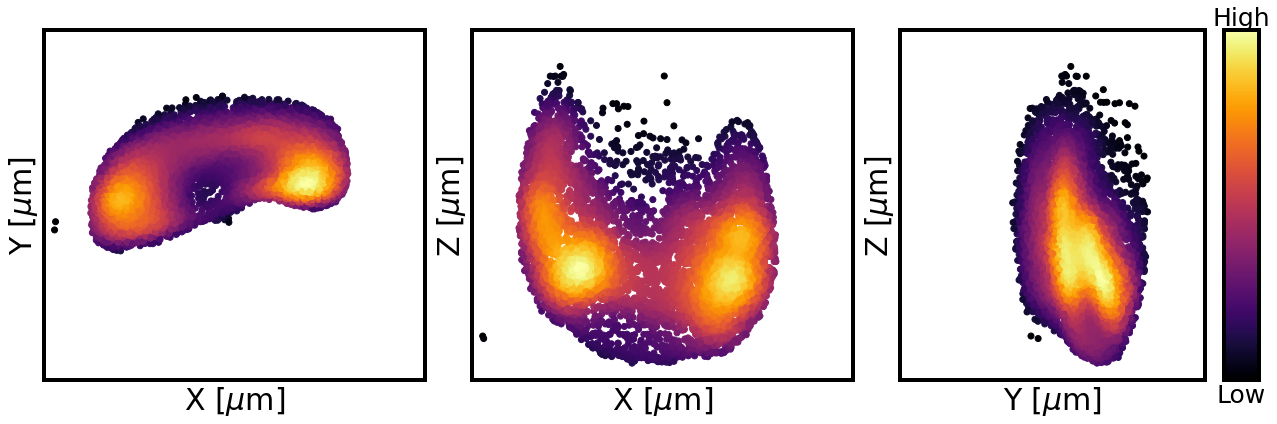

In [8]:
# Plot the results
combs = list(itertools.combinations(range(3), 2))
labels_axis = ['X [$\mu$m]', 'Y [$\mu$m]', 'Z [$\mu$m]']
sizes = [features.width*features.x_pixel, features.height*features.y_pixel, 
         features.n_slices*features.z_pixel]
pixels = [features.x_pixel, features.y_pixel, features.z_pixel]

fig = plt.figure(figsize=[18,6])

for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plt.scatter(data[combs[i][0]], data[combs[i][1]], c=gkd[i], cmap=cmap)
    plt.xlabel(labels_axis[combs[i][0]], fontsize=30)
    plt.ylabel(labels_axis[combs[i][1]], fontsize=30)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([0, sizes[combs[i][0]]])
    plt.ylim([0, sizes[combs[i][1]]])
    [i.set_linewidth(4) for i in ax.spines.values()]
    
# Colorbar
cb = plt.colorbar(ticks=[], aspect=10)
cb.outline.set_linewidth(4)
cb.ax.text(0.5, -0.01, 'Low', transform=cb.ax.transAxes, 
    va='top', ha='center', fontsize=25)
cb.ax.text(0.5, 1.0, 'High', transform=cb.ax.transAxes, 
    va='bottom', ha='center', fontsize=25);

plt.tight_layout()

## LabKit Data

Here we read the labels you created using Labkit. Later in the code, we will remove all the tracks which are not contained in your label(s) and we will resave the -mamut.xml file containing the tracks for each label individually. 

Here we create an object called ``labkit`` which contains:
- ``masks`` : The binary masks created from the Labkit Fiji Plugin
- ``spots_to_keep`` : The ID of the spots to keep (which are contained inside the mask defined before)


In [9]:
labkit = paleo_bulk.LabkitData(path_labels, path_xml, path_mamut)

TypeError: 'int' object is not iterable

#### Plot the mask results

In [ ]:
cmap = 'Greys_r'

In [ ]:
fig = plt.figure(figsize=[18,6])

for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)

    plt.imshow(labkit.masks[i], cmap=cmap, alpha=1, aspect='auto')
    plt.xticks(np.arange(1), fontsize=25);
    plt.yticks(np.arange(1), fontsize=25);
    plt.xlabel(labels_axis[combs[i][0]], fontsize=30)
    plt.ylabel(labels_axis[combs[i][1]], fontsize=30)
    [i.set_linewidth(4) for i in ax.spines.values()]
    plt.gca().invert_yaxis()
    
plt.tight_layout()

## Spots tp keep according to labeling

Here we chose the spots we want to keep according to the labling we previously showed from labkit. 

### Sanity check: Are your labels and mastodon tracks ok?

Here we overlap the mastodon spots and the labels to check whether they overlap. If they do not, please check the frame you chose to plot the label and that the xml pixels sizes are correct. 

The spots shown below are the ones you decided to keep for the specific frame you chose. 

In [ ]:
fig = plt.figure(figsize=[18,6])

for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    
    # Plot each label

    for label in range(len(labkit.labels)):
        if np.size(np.array(labkit.spots_to_keep[label])) > 0:
            plt.scatter(np.array(data[combs[i][0]])[np.array(labkit.spots_to_keep[label])]/pixels[combs[i][0]],\
                        np.array(data[combs[i][1]])[np.array(labkit.spots_to_keep[label])]/pixels[combs[i][1]], 
                        c=colors[label], edgecolor='k', alpha=1, zorder=10, label=labkit.labels[label], s=20)
        
    plt.legend(loc='best', fontsize=16)

    plt.imshow(labkit.masks[i].T, cmap='Greys', alpha=0.4, aspect='auto')
    plt.xticks(np.arange(1), fontsize=25);
    plt.yticks(np.arange(1), fontsize=25);
    plt.xlabel(labels_axis[combs[i][0]], fontsize=30)
    plt.ylabel(labels_axis[combs[i][1]], fontsize=30)

    [i.set_linewidth(4) for i in ax.spines.values()];

plt.tight_layout()
plt.show()

### 3D Visualization

In [ ]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 3, 1, projection='3d')


# Data for three-dimensional scattered points
zdata = z 
xdata = x 
ydata = y 

ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greys', s=5, alpha=0.05, zorder=0);

for label in range(len(labkit.labels)):

    if np.size(np.array(labkit.spots_to_keep[label])) > 0:
        
        x_keep = np.array(x)[np.array(labkit.spots_to_keep[label])]
        y_keep = np.array(y)[np.array(labkit.spots_to_keep[label])]
        z_keep = np.array(z)[np.array(labkit.spots_to_keep[label])]
    
        ax.scatter3D(x_keep, y_keep, z_keep, c=z_keep, cmap='inferno', s=5, alpha=1,
                    zorder=20)

ax.grid(False)

ax.set_xticks([]);
ax.set_yticks([]);
ax.set_zticks([]);

ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)

ax = fig.add_subplot(1, 3, 2, projection='3d')

# Data for three-dimensional scattered points
zdata = z
xdata = x 
ydata = y 
ax.scatter3D(xdata, zdata, ydata, c=ydata, cmap='Greys', s=5, alpha=0.05, zorder=0);

for label in range(len(labkit.labels)):

    if np.size(np.array(labkit.spots_to_keep[label])) > 0:
        
        x_keep = np.array(x)[np.array(labkit.spots_to_keep[label])]
        y_keep = np.array(y)[np.array(labkit.spots_to_keep[label])]
        z_keep = np.array(z)[np.array(labkit.spots_to_keep[label])]
    
        ax.scatter3D(x_keep, z_keep, y_keep, c=y_keep, cmap='inferno', s=5, alpha=1,
                    zorder=20)
        
ax.grid(False)

ax.set_xticks([]);
ax.set_yticks([]);
ax.set_zticks([]);

ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Z', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

ax = fig.add_subplot(1, 3, 3, projection='3d')

# Data for three-dimensional scattered points
zdata = z
xdata = x 
ydata = y 
ax.scatter3D(ydata, zdata, xdata, c=xdata, cmap='Greys', s=5, alpha=0.05, zorder=0);

for label in range(len(labkit.labels)):

    if np.size(np.array(labkit.spots_to_keep[label])) > 0:
        
        x_keep = np.array(x)[np.array(labkit.spots_to_keep[label])]
        y_keep = np.array(y)[np.array(labkit.spots_to_keep[label])]
        z_keep = np.array(z)[np.array(labkit.spots_to_keep[label])]
    
        ax.scatter3D(y_keep, z_keep, x_keep, c=x_keep, cmap='inferno', s=5, alpha=1,
                    zorder=20)
        
ax.grid(False)

ax.set_xticks([]);
ax.set_yticks([]);
ax.set_zticks([]);

ax.set_xlabel('Y', fontsize=20)
ax.set_ylabel('Z', fontsize=20)
ax.set_zlabel('X', fontsize=20)

plt.show()

## Remove Spots which are not in the PSM

In [ ]:
paleo_bulk.SpotsRemoval(path_save, path_mamut, path_labels, path_xml)